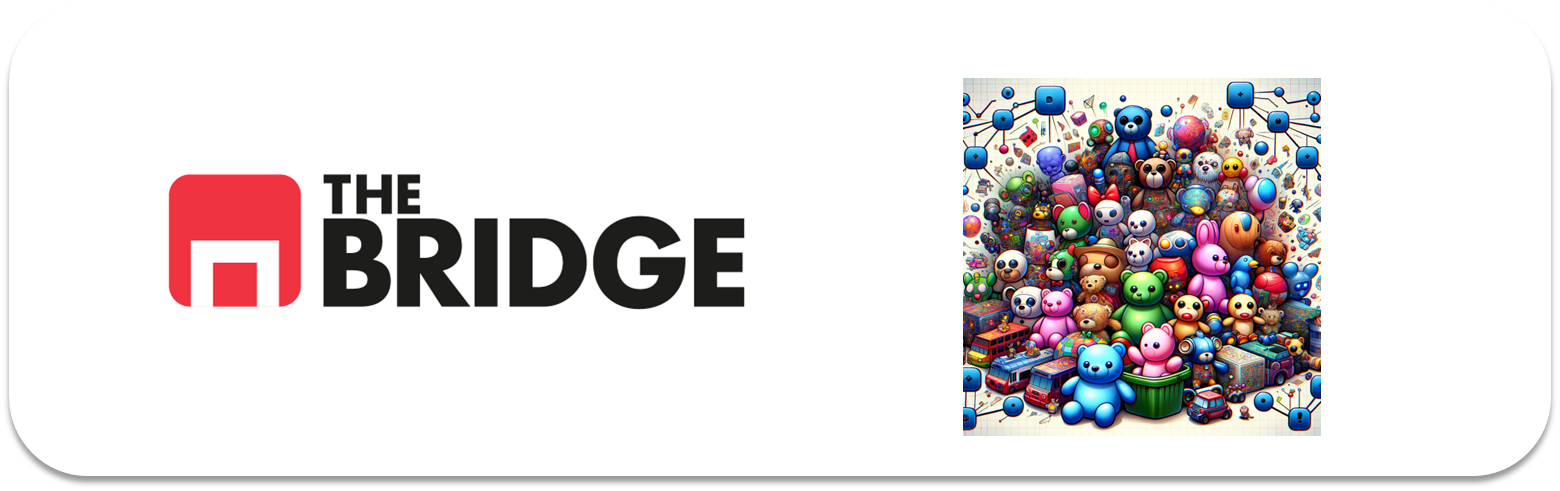

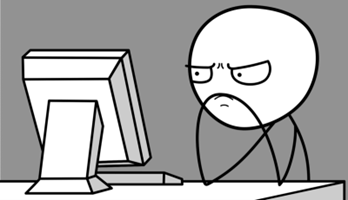

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.preprocessing import MinMaxScaler

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [2]:
df = pd.read_csv('data/drugLibTrain_raw.tsv', sep = '\t')
df.head(5)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


Hay valores nulos en las columnas "condition", "benefitsReview", "sideEffectsReview" y "commentsReview". Eliminamos la columna "Unnamed: 0"

In [4]:
df.drop(columns= 'Unnamed: 0', inplace= True)

### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [5]:
#Calculamos la cardinalidad
pd.DataFrame({"Cardinalidad": df.nunique(), "% Card": (df.nunique()/df.count())*100.0})

,Cardinalidad,% Card
urlDrugName,502,16.157065
rating,10,0.321854
effectiveness,5,0.160927
sideEffects,5,0.160927
condition,1426,45.911140
benefitsReview,3031,98.122370
sideEffectsReview,2813,92.777045
commentsReview,3046,98.416801


Vemos que las variables "benefitsReview", "sideEffectsReview" y "commentsReview" tienen muchos valores únicos (son poco informativas) y no son útiles para clasificar. Las que mejor podrían ayudar a la clasificación son "rating", "effectiveness", "sideEffects"

### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [6]:
X = df[['rating', 'sideEffects', 'effectiveness']].copy()
X.head()

,rating,sideEffects,effectiveness
0,4,Mild Side Effects,Highly Effective
1,1,Severe Side Effects,Highly Effective
2,10,No Side Effects,Highly Effective
3,3,Mild Side Effects,Marginally Effective
4,2,Severe Side Effects,Marginally Effective


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

Realizamos la codificación ordinal de "sideEffects" y "effectiveness"

In [7]:
X["sideEffects"].value_counts()

sideEffects
Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: count, dtype: int64

In [8]:
X["effectiveness"].value_counts()

effectiveness
Highly Effective          1330
Considerably Effective     928
Moderately Effective       415
Ineffective                247
Marginally Effective       187
Name: count, dtype: int64

In [9]:
#Mapeos para las columnas categoricas
side_eff_map = {'Mild Side Effects': 1, 'Severe Side Effects': 3, 'No Side Effects': 0,
       'Extremely Severe Side Effects': 4, 'Moderate Side Effects': 2}

effect_map = {'Highly Effective': 4, 'Marginally Effective': 1, 'Ineffective': 0,
       'Considerably Effective': 3, 'Moderately Effective': 2}

#Aplicamos los mapeos
X['sideEffects'] = X['sideEffects'].map(side_eff_map)

X['effectiveness'] = X['effectiveness'].map(effect_map)

In [10]:
X.head()

,rating,sideEffects,effectiveness
0,4,1,4
1,1,3,4
2,10,0,4
3,3,1,1
4,2,3,1


Realizamos el escalado de las *features*

In [11]:
minmax = MinMaxScaler()
minmax.fit(X)
X[X.columns] = minmax.transform(X)

In [13]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,3107.0,0.667346,0.326398,0.0,0.444444,0.777778,0.888889,1.0
sideEffects,3107.0,0.326199,0.294371,0.0,0.000000,0.250000,0.500000,1.0
effectiveness,3107.0,0.733907,0.307633,0.0,0.500000,0.750000,1.000000,1.0


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

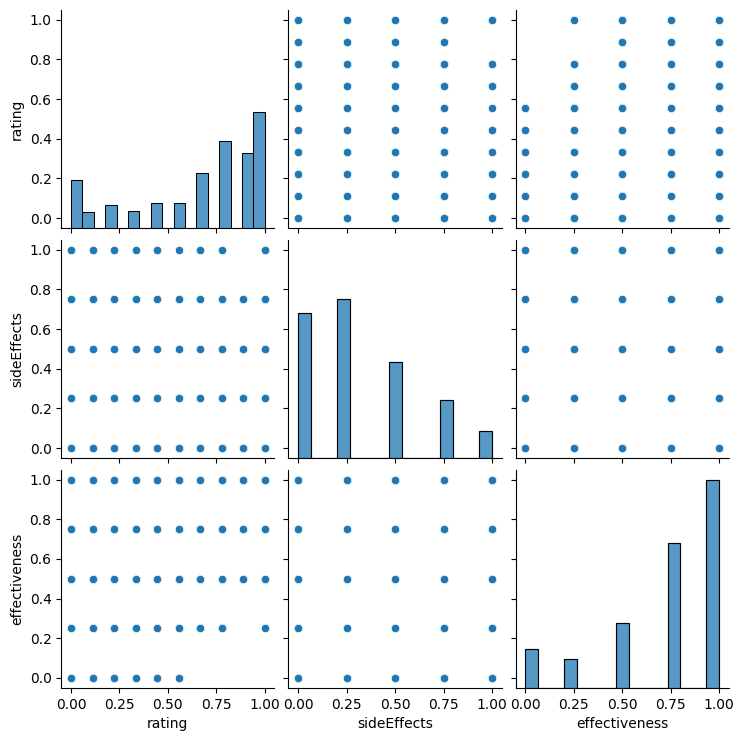

In [14]:
sns.pairplot(X);

Observamos que los medicamentos con poca efectividad, con muchos efectos secundarios y los que tienen poco rating, los hay en menor cantidad que sus contrapartes (hay una mayoría de medicamentos "buenos"). Por otro lado no se ve una clusterizacion clara

Vamos a visualizar en función de "effectiveness"

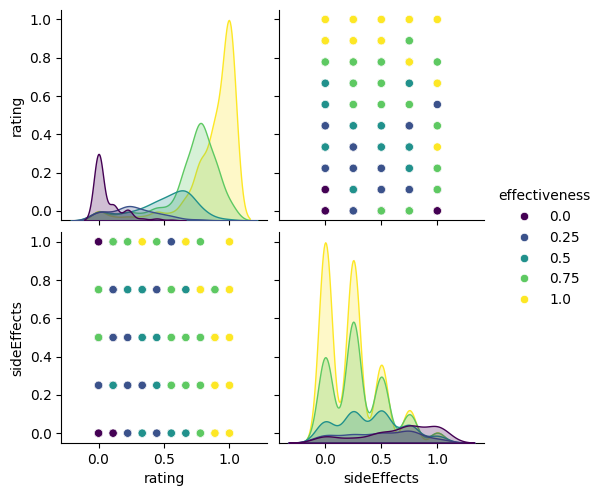

In [15]:
sns.pairplot(X, hue = "effectiveness", palette="viridis");

No se ve nada muy evidente, pero en la gráfica superior derecha los colores tienden a ser más claros medida aumenta "rating" y también a medida que disminuye "sideEffects", lo que indica una relación trivariante que sí puede manifestarse en la existencia de clústeres.

Se sugieren dos posibles agrupaciones de 2 o 3 clústeres visuales que no tienen por qué ser los que encuentre el modelo pero que podríamos esperar

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

In [22]:
#Probamos con diferentes valores de k
ks = []
inertias = []

for k in range(1, 10):
    
    clustering = KMeans(n_clusters = k, random_state=42)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    ks.append(k)

#Creamos un Dataframe con las inercias
df_inertias = pd.DataFrame({'k': ks, 'inertia': inertias})

#Creamos una columna con la variacion de las inercias
df_inertias['diff'] = df_inertias['inertia'] - df_inertias['inertia'].shift(1)
df_inertias

c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

,k,inertia,diff
0,1,893.992575,NaN
1,2,395.471897,-498.520678
2,3,299.907623,-95.564274
3,4,237.358562,-62.549061
4,5,188.373019,-48.985542
5,6,153.959304,-34.413716
6,7,134.483035,-19.476269
7,8,118.130117,-16.352918
8,9,105.115217,-13.014900


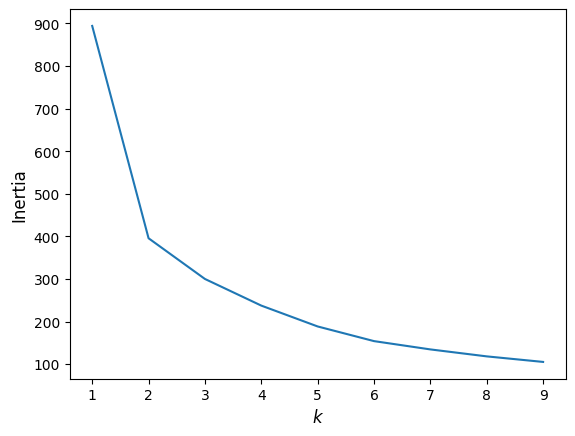

In [23]:
#Gráfica de las inercias en funcion de k
plt.plot(ks, inertias)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Inertia", fontsize=12);

Tanto en los valores del DataFrame como en la gráfica del codo se observa que el mayor cambio se produce entre k=1 (un cluster) y k=2 (dos clusters), y luego se aprecia otro cambio menos pronunciado entre k=2 y k=3. El codo podría estar en k=2 o k=3

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

In [25]:
#Calculamos el silhouette score para cada k
ks = []
sil_scores = []

for k in range(2, 10): 
    clustering = KMeans(n_clusters = k, random_state=42)
    clustering.fit(X)

    sil_scores.append(silhouette_score(X, clustering.labels_))
    ks.append(k)

c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

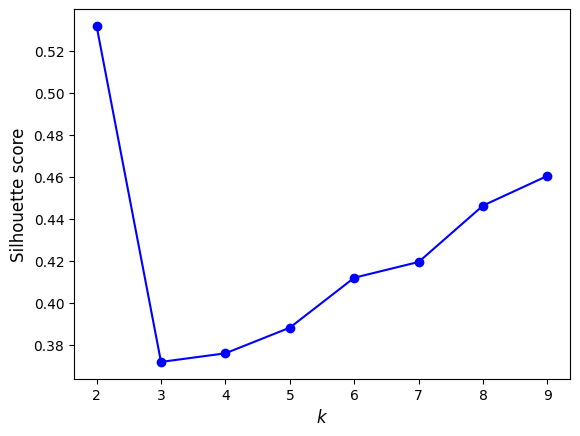

In [26]:
# Graficamos el silhouette score para cada k
plt.plot(ks, sil_scores, "bo-");
plt.xlabel("$k$", fontsize=12);
plt.ylabel("Silhouette score", fontsize=12);

El silhouette score mas alto se da para k=2, esto quiere decir que hay 2 clusters bien diferenciados entre ellos

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

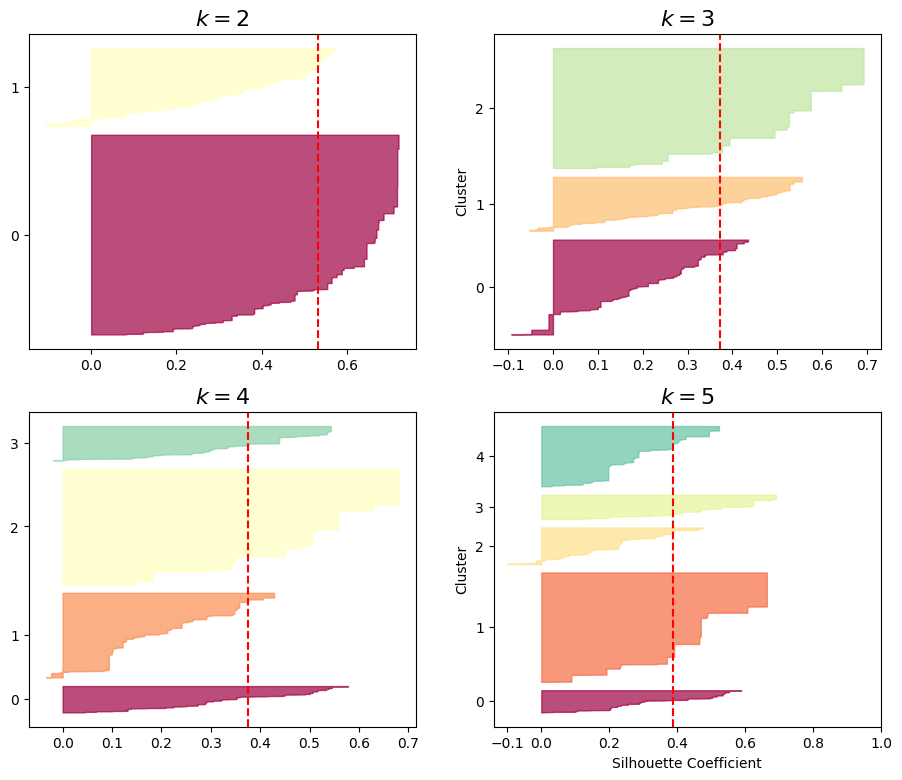

In [32]:
'''
La anchura de cada cuchillo representa el numero de muestras por cluster. Están ordenadas
por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. Cuanta más caida tenga
indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas lineas hacia la izquierda porque tienen el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    clustering = KMeans(n_clusters = k, random_state=42)
    clustering.fit(X)
    y_pred = clustering.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=sil_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

Comentarios:
* Para k=3, k=4 y k=5 tiene el problema de tener un score de silueta más bajos que para k=2
* Para los k=3 y k=4 hay más coeficientes negativos que indican problemas en la delimitación de los clústeres

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [33]:
#KMeans con k = 2
clustering_k2 = KMeans(n_clusters= 2, random_state=42)
clustering_k2.fit(X)

c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

Creamos una nueva columna que indica el cluster asignado a cada observacion

In [34]:
X['cluster'] = clustering_k2.predict(X)
X.head()

,rating,sideEffects,effectiveness,cluster
0,0.333333,0.25,1.00,0
1,0.000000,0.75,1.00,1
2,1.000000,0.00,1.00,0
3,0.222222,0.25,0.25,1
4,0.111111,0.75,0.25,1


In [35]:
#Vemos la distribución de elementos en cada cluster
X['cluster'].value_counts(normalize= True)

cluster
0    0.720309
1    0.279691
Name: proportion, dtype: float64

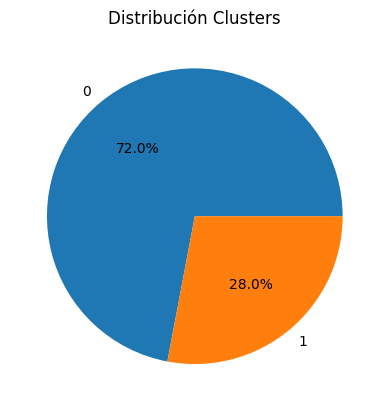

In [36]:
#Visualizamos con un pie chart
plt.pie(X['cluster'].value_counts(normalize= True), autopct= '%1.1f%%', labels= ['0', '1'])
plt.title('Distribución Clusters');

Hay mas elementos en el cluster 0 que en el cluster 1. Analizamos las estadísticas de cada grupo

In [37]:
X.groupby('cluster').describe()

rating                                                              \
          count      mean       std  min       25%       50%       75%  max   
cluster                                                                       
0        2238.0  0.842369  0.146383  0.0  0.777778  0.888889  1.000000  1.0   
1         869.0  0.216596  0.208818  0.0  0.000000  0.222222  0.333333  1.0   

        sideEffects            ...            effectiveness            \
              count      mean  ...   75%  max         count      mean   
cluster                        ...                                      
0            2238.0  0.209674  ...  0.25  1.0        2238.0  0.868409   
1             869.0  0.626295  ...  0.75  1.0         869.0  0.387514   

                                              
              std   min   25%  50%  75%  max  
cluster                                       
0        0.164449  0.25  0.75  1.0  1.0  1.0  
1        0.319656  0.00  0.00  0.5  0.5  1.0  

[2 rows x 24 columns]

El cluster 0 tiene mayor cantidad de elementos, una media de rating y efectividad mas alta, así como una media de efectos secundarios mas baja que el cluster 1, esto quiere decir que estamos ante medicamentos que en general funcionan bien en el cluster 0 vs los que no en el cluster 1


Etiquetamos los grupos llamándolos "Bueno" y "Malo"

In [38]:
#Mapeo para la columna "cluster"
cluster_map = {0: 'Bueno', 1: 'Malo'}

#Aplicamos el mapeo
X['Label'] = X['cluster'].map(cluster_map)
X.head()

,rating,sideEffects,effectiveness,cluster,Label
0,0.333333,0.25,1.00,0,Bueno
1,0.000000,0.75,1.00,1,Malo
2,1.000000,0.00,1.00,0,Bueno
3,0.222222,0.25,0.25,1,Malo
4,0.111111,0.75,0.25,1,Malo


Observamos ahora el pairplot

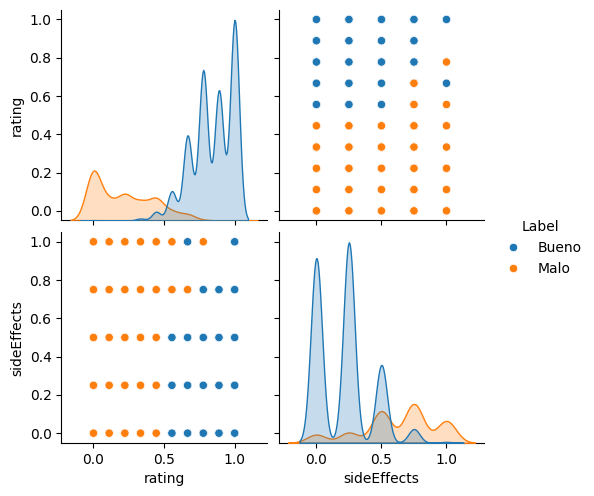

In [39]:
#Podemos ver la distribucion de los clusters en el espacio de las variables
sns.pairplot(data= X[['rating', 'sideEffects', 'Label']], hue= 'Label');

El clustering ha encontrado agrupaciones que tienen sentido con el análisis previo realizado

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

Probamos con k=3

In [40]:
#Eliminamos la columna creada anteriormente de X
X.drop(columns=["Label"], inplace=True)

#Kmeans con k = 3
clustering_k3 = KMeans(n_clusters= 3, random_state=42)
clustering_k3.fit(X)

c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

Creamos una nueva columna que indica el cluster asignado a cada observacion

In [41]:
X['cluster'] = clustering_k3.predict(X)
X.head()

,rating,sideEffects,effectiveness,cluster
0,0.333333,0.25,1.00,0
1,0.000000,0.75,1.00,1
2,1.000000,0.00,1.00,2
3,0.222222,0.25,0.25,1
4,0.111111,0.75,0.25,1


In [42]:
#Vemos la distribución de elementos en cada cluster
X.cluster.value_counts(True)

cluster
2    0.370132
0    0.350177
1    0.279691
Name: proportion, dtype: float64

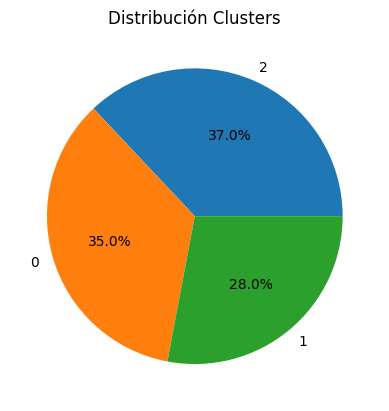

In [43]:
#Visualizamos con un pie chart
plt.pie(X['cluster'].value_counts(normalize= True), autopct= '%1.1f%%', labels= ['2', '0', '1'])
plt.title('Distribución Clusters');

Hay una distribución más uniforme, como ya se observó en el análisis del diagrama de siluetas. Analizamos las estadísticas de cada grupo

In [44]:
X.groupby("cluster").describe()

rating                                                              \
          count      mean       std       min       25%       50%       75%   
cluster                                                                       
0        1088.0  0.733762  0.122082  0.000000  0.666667  0.777778  0.777778   
1         869.0  0.216596  0.208818  0.000000  0.000000  0.222222  0.333333   
2        1150.0  0.945121  0.076696  0.666667  0.888889  1.000000  1.000000   

             sideEffects            ...             effectiveness            \
         max       count      mean  ...   75%   max         count      mean   
cluster                             ...                                       
0        1.0      1088.0  0.338695  ...  0.50  1.00        1088.0  0.784926   
1        1.0       869.0  0.626295  ...  0.75  1.00         869.0  0.387514   
2        1.0      1150.0  0.087609  ...  0.25  0.25        1150.0  0.947391   

                                               
              std   min   25%   50%  75%  max  
cluster                                        
0        0.175022  0.25  0.75  0.75  1.0  1.0  
1        0.319656  0.00  0.00  0.50  0.5  1.0  
2        0.104061  0.50  1.00  1.00  1.0  1.0  

[3 rows x 24 columns]

Se observan las mismas relaciones en cuanto a las medias de "rating", "sideEffects" y "effectiveness". 

Etiquetamos los grupos llamándolos "Muy bueno", "Bueno" y "Malo"

In [45]:
#Mapeo para la columna "cluster"
cluster_map = {0: 'Bueno', 1: 'Malo', 2: "Muy bueno"}

#Aplicamos el mapeo
X['Label'] = X['cluster'].map(cluster_map)
X.head()

,rating,sideEffects,effectiveness,cluster,Label
0,0.333333,0.25,1.00,0,Bueno
1,0.000000,0.75,1.00,1,Malo
2,1.000000,0.00,1.00,2,Muy bueno
3,0.222222,0.25,0.25,1,Malo
4,0.111111,0.75,0.25,1,Malo


Observamos ahora el pairplot

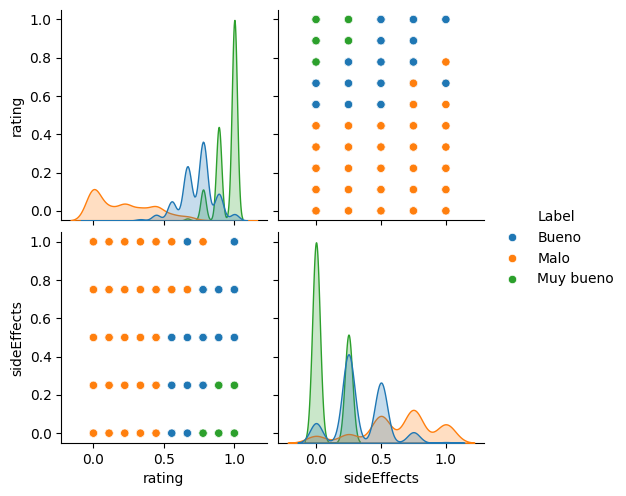

In [46]:
#Podemos ver la distribucion de los clusters en el espacio de las variables
sns.pairplot(data= X[['rating', 'sideEffects', 'Label']], hue= 'Label');

También se obtiene una buena clusterización y quizás incluso mas fina que con k=2